In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import joblib
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange


from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

#from udf import powerLawFit, fit_hist, MB_2D, normal_distr, get_trajs, speed_windowed, theta_windowed

show_verb = True
save_verb = True
anim_show_verb = False

In [2]:
import numpy as np
import trackpy as tp
from scipy.optimize import curve_fit
from yupi import Trajectory
import yupi.stats as ys
from tqdm import tqdm

# get trajectories
def get_trajs(nDrops, red_particle_idx, trajs):
    # raw trajectories
    blueTrajs = []
    redTraj = []
    for i in range(0, nDrops):
        if i == red_particle_idx:
            p = trajs.loc[trajs.particle == i, ["x","y"]]
            redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        else:
            p = trajs.loc[trajs.particle == i, ["x","y"]]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    return blueTrajs, redTraj


# get speed distributions windowed in time
def speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajs):
    v_blue_wind = []
    v_red_wind = []
    for k in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs = []
        redTraj = []
        for i in range(0, nDrops):
            if i == red_particle_idx:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
            else:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        v_blue_wind.append(ys.speed_ensemble(blueTrajs, step=10))
        v_red_wind.append(ys.speed_ensemble(redTraj, step=10))
    return v_blue_wind, v_red_wind
    

# get turning angles distributions windowed in time
def theta_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajs):
    theta_blue_wind = []
    theta_red_wind = []
    for k in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs = []
        redTraj = []
        for i in range(0, nDrops):
            if i == red_particle_idx:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
            else:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        theta_blue_wind.append(ys.turning_angles_ensemble(blueTrajs, centered= True))
        theta_red_wind.append(ys.turning_angles_ensemble(redTraj, centered= True))
    return theta_blue_wind, theta_red_wind


# Power Law fit
def powerLaw(x, a, k):
    return a*x**k


def powerLawFit(f, x, nDrops, yerr):
    if nDrops == 1:
        ret = np.zeros((2, 2))
        ret[0], pcov = curve_fit(powerLaw, x, f, p0 = [1., 1.])
        ret[1] = np.sqrt(np.diag(pcov))
        fit = ret[0, 0] * x**ret[0, 1]
    else:
        fit = np.zeros((nDrops, f.shape[0])) # np.zeros(f.shape).T
        ret = np.zeros((nDrops, 2, 2))
        for i in range(nDrops):
            if yerr is None:
                ret[i, 0], pcov = curve_fit(powerLaw, x, f[i], p0 = [1., 1.])
            else:
                ret[i, 0], pcov = curve_fit(powerLaw, x, f[i], p0 = [1., 1.], sigma = yerr)
            ret[i, 1] = np.sqrt(np.diag(pcov))
            fit[i] = ret[i, 0, 0] * x**ret[i, 0, 1]
    return fit, ret 


def get_imsd(trajs, pxDimension, fps, maxLagtime, nDrops):
    imsd = tp.imsd(trajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
    fit, pw_exp = powerLawFit(imsd[1:], imsd[1:].index, nDrops, None)
    return imsd, fit, pw_exp


def get_emsd(imsd, x, red_particle_idx, nDrops):
    MSD = np.array(imsd)
    MSD_b = [MSD[:, [x for x in range(nDrops) if x != red_particle_idx]].mean(axis = 1),
                MSD[:,[x for x in range(nDrops) if x != red_particle_idx]].std(axis = 1)]
    MSD_r = MSD[:, red_particle_idx]
    fit_b, pw_exp_b = powerLawFit(MSD_b[0][9:], x, 1, MSD_b[1][9:])
    fit_r, pw_exp_r = powerLawFit(MSD_r[9:], x, 1, None)
    res = {"fit_b":fit_b, "pw_exp_b":pw_exp_b, "fit_r":fit_r, "pw_exp_r":pw_exp_r}
    return MSD_b, MSD_r, res


# 2D Maxwell-Boltzmann distribution
def MB_2D(v, sigma):
    return v/(sigma**2) * np.exp(-v**2/(2*sigma**2))


# Normal distribution
def normal_distr(x, sigma, mu):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((x-mu)/sigma)**2)


# Histogram fit
def fit_hist(y, bins_, distribution, p0_):
    bins_c = bins_[:-1] + np.diff(bins_) / 2
    bin_heights, _ = np.histogram(y, bins = bins_, density = True)
    ret, pcov = curve_fit(distribution, bins_c, bin_heights, p0 = p0_)
    ret_std = np.sqrt(np.diag(pcov))
    return ret, ret_std


def get_imsd_windowed(nSteps, startFrames, endFrames, trajs, pxDimension, fps, maxLagtime, nDrops):
    MSD_wind = []
    fit_wind = np.zeros((nSteps, nDrops, maxLagtime-9))
    pw_exp_wind = np.zeros((nSteps, nDrops, 2, 2))
    for i in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[i], endFrames[i])]
        temp, fit_wind[i], pw_exp_wind[i] = get_imsd(trajs_wind, pxDimension, fps, maxLagtime, nDrops)
        MSD_wind.append(temp)
    return MSD_wind, fit_wind, pw_exp_wind

def get_emsd_windowed(imsds, x, nDrops, red_particle_idx, nSteps, maxLagtime):
    EMSD_wind = np.array(imsds)
    EMSD_wind_b = [EMSD_wind[:, :, [x for x in range(nDrops) if x != red_particle_idx]].mean(axis = 2), 
                    EMSD_wind[:, :, [x for x in range(nDrops) if x != red_particle_idx]].std(axis = 2)]
    EMSD_wind_r = EMSD_wind[:, :, red_particle_idx]

    fit_wind_b = np.zeros((nSteps, maxLagtime-9))
    pw_exp_wind_b = np.zeros((nSteps, 2, 2))
    fit_wind_r = np.zeros((nSteps, maxLagtime-9))
    pw_exp_wind_r = np.zeros((nSteps, 2, 2))

    for i in tqdm(range(nSteps)):
        fit_wind_b[i], pw_exp_wind_b[i] = powerLawFit(EMSD_wind_b[0][i, 9:], x, 1, EMSD_wind_b[1][i, 9:])
        fit_wind_r[i], pw_exp_wind_r[i] = powerLawFit(EMSD_wind_r[i, 9:], x, 1, None)
    
    res = {"fit_wind_b":fit_wind_b, "pw_exp_wind_b":pw_exp_wind_b, "fit_wind_r":fit_wind_r, "pw_exp_wind_r":pw_exp_wind_r}

    return EMSD_wind_b, EMSD_wind_r, res

In [3]:
rawTrajs = pd.read_parquet("../data/tracking/pre_merge_tracking.parquet")
red_particle_idx = 17
rawTrajs.loc[rawTrajs.particle != red_particle_idx, ["color"]] = "#00007F"
rawTrajs.loc[rawTrajs.particle == red_particle_idx, ["color"]] = "#FF0000"
colors = rawTrajs.loc[rawTrajs.frame == 0, 'color'].values
nDrops = len(rawTrajs.loc[rawTrajs.frame==0])
nFrames = max(rawTrajs.frame) + 1
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")


# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")


# step 10 with a 10 fps video --> 1 s
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

nDrops:50
nFrames:32000 --> 3200.00 s
window of 320.0 s, stride of 10.0 s
number of steps: 288


In [4]:
# Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
smoothTrajs = rawTrajs.copy()
windLen = 30
orderofPoly = 2
for i in range(nDrops):
    smoothTrajs.loc[smoothTrajs.particle == i, "x"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].x.values,
                                                                    windLen, orderofPoly)
    smoothTrajs.loc[smoothTrajs.particle == i, "y"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].y.values,
                                                                    windLen, orderofPoly)        

# Mean Squared Displacement

In [5]:
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered
#x = np.array(imsd[1:].index)
x = np.arange(1., 100.1, .1)

## Individual MSD

In [6]:
imsd, fit, pw_exp = get_imsd(rawTrajs, pxDimension, fps, maxLagtime, nDrops)
imsd_smooth, fit_smooth, pw_exp_smooth = get_imsd(smoothTrajs, pxDimension, fps, maxLagtime, nDrops)

In [7]:
# residual sum of squares
y = imsd[1:][0]
y_fit = fit[0]
ss_res = np.sum((y - y_fit) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
print(1 - (ss_res / ss_tot))

y = imsd_smooth[1:][0]
y_fit = fit_smooth[0]
ss_res = np.sum((y - y_fit) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
print(1 - (ss_res / ss_tot))

0.9999814141652471
0.9999778393291987


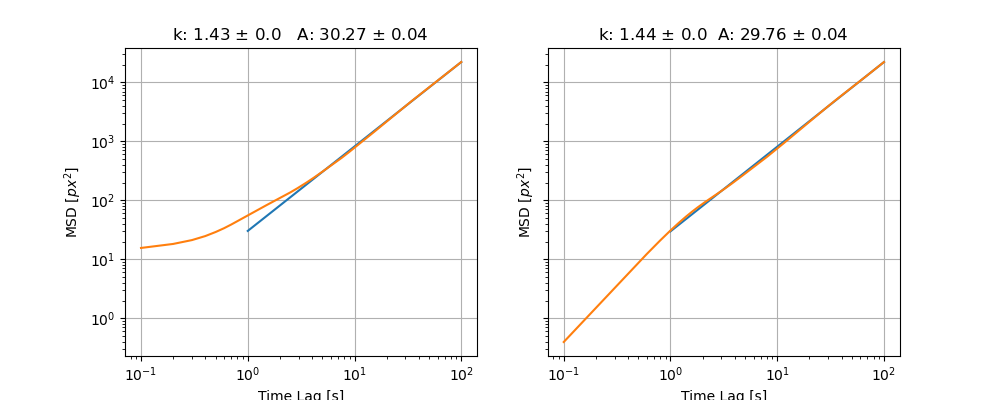

In [8]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 4), sharey=True)
ax.plot(imsd[1:].index, fit[0])
ax.plot(imsd.index, imsd[0])
ax.set_title(f"k: {round(pw_exp[0, 0, 1], 2)} $\pm$ {round(pw_exp[0, 1, 1], 2)}   A: {round(pw_exp[0, 0, 0], 2)} $\pm$ {round(pw_exp[0, 1, 0], 2)} ")
ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = "MSD [$px^2$]")
ax.grid()

ax1.plot(imsd_smooth[1:].index, fit_smooth[0])
ax1.plot(imsd_smooth.index, imsd_smooth[0])
ax1.set_title(f"k: {round(pw_exp_smooth[0, 0, 1], 2)} $\pm$ {round(pw_exp_smooth[0, 1, 1], 2)}  A: {round(pw_exp_smooth[0, 0, 0], 2)} $\pm$ {round(pw_exp_smooth[0, 1, 0], 2)} ")
ax1.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = "MSD [$px^2$]")
ax1.grid()
plt.show()

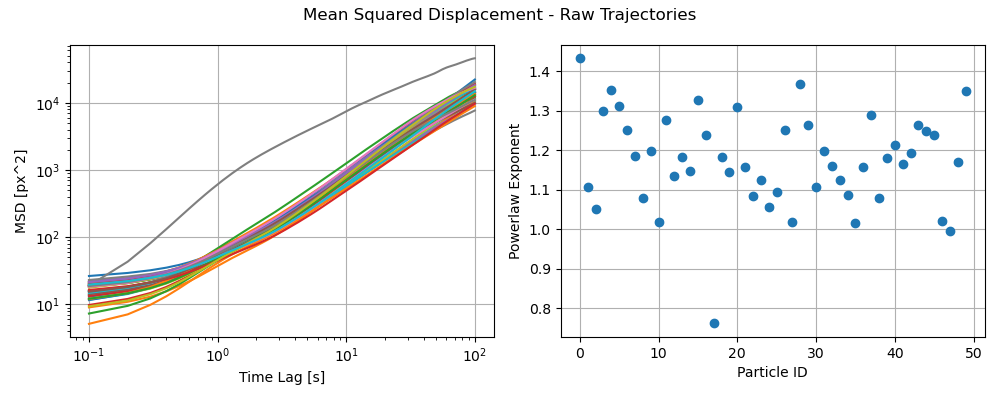

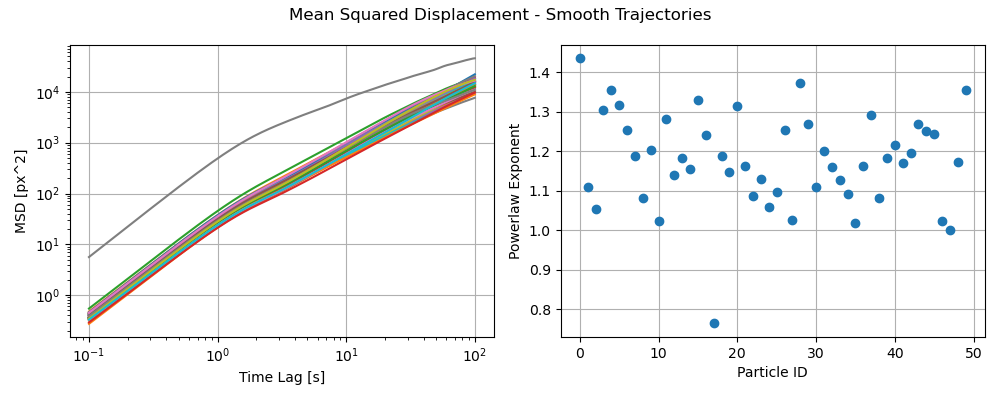

In [9]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.plot(imsd.index, imsd)
ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = "MSD [px^2]")
ax.grid()
ax1.errorbar(np.arange(nDrops), pw_exp[:, 0, 1], yerr=pw_exp[:, 1, 1], fmt = 'o', capsize = 3)
ax1.set(xlabel = "Particle ID", ylabel = "Powerlaw Exponent")
ax1.grid()
plt.suptitle("Mean Squared Displacement - Raw Trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/mean_squared_displacement/IMSD_raw.png", dpi = 500)
if show_verb: 
    plt.show()
else:
    plt.close()

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.plot(imsd_smooth.index, imsd_smooth)
ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = "MSD [px^2]")
ax.grid()
ax1.errorbar(np.arange(nDrops), pw_exp_smooth[:, 0, 1], yerr=pw_exp_smooth[:, 1, 1], fmt = 'o', capsize = 3)
ax1.set(xlabel = "Particle ID", ylabel = "Powerlaw Exponent")
ax1.grid()
plt.suptitle("Mean Squared Displacement - Smooth Trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/mean_squared_displacement/IMSD_smooth.png", dpi = 500)
if show_verb: 
    plt.show()
else:
    plt.close()


## Ensamble MSD

In [10]:
MSD_b, MSD_r, fit = get_emsd(imsd, x, red_particle_idx, nDrops)
MSD_b_smooth, MSD_r_smooth, fit_smooth = get_emsd(imsd_smooth, x, red_particle_idx, nDrops)

Raw trajs - Blue Particles: 1.179 ± 0.002, Red Particle: 0.762 ± 0.002


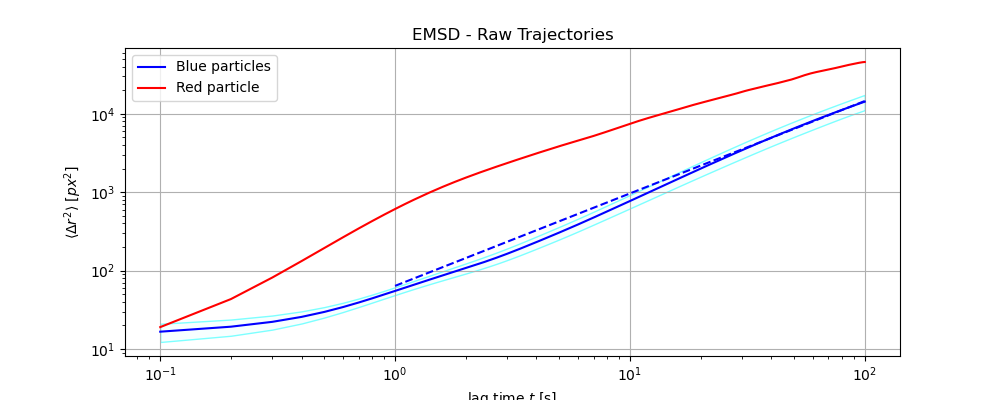

Smooth trajs - Blue Particles: 1.183 ± 0.002, Red Particle: 0.765 ± 0.002


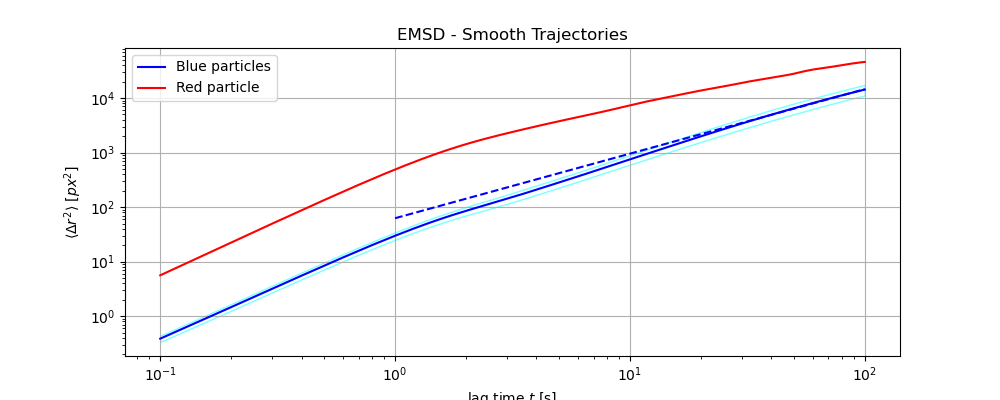

In [11]:
a = [round(fit["pw_exp_b"][0, 1], 3), round(fit["pw_exp_b"][1, 1], 3)]
b = [round(fit["pw_exp_r"][0, 1], 3), round(fit["pw_exp_r"][1, 1], 3)]
print(f"Raw trajs - Blue Particles: {a[0]} ± {a[1]}, Red Particle: {b[0]} ± {b[1]}")
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(imsd.index, MSD_b[0], 'b-', label = "Blue particles") 
ax.plot(imsd[1:].index, fit["fit_b"], 'b--')
ax.fill_between(imsd.index, MSD_b[0] - MSD_b[1], MSD_b[0] + MSD_b[1], alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax.plot(imsd.index, MSD_r, 'r-', label = "Red particle")
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',   
        xlabel = 'lag time $t$ [s]', title = "EMSD - Raw Trajectories")
ax.legend()
ax.grid()
if save_verb: plt.savefig("../results/mean_squared_displacement/EMSD_raw.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()
    

a = [round(fit_smooth["pw_exp_b"][0, 1], 3), round(fit_smooth["pw_exp_b"][1, 1], 3)]
b = [round(fit_smooth["pw_exp_r"][0, 1], 3), round(fit_smooth["pw_exp_r"][1, 1], 3)]
print(f"Smooth trajs - Blue Particles: {a[0]} ± {a[1]}, Red Particle: {b[0]} ± {b[1]}")
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(imsd_smooth.index, MSD_b_smooth[0], 'b-', label = "Blue particles") 
ax.plot(imsd_smooth[1:].index, fit_smooth["fit_b"], 'b--')
ax.fill_between(imsd_smooth.index, MSD_b_smooth[0] - MSD_b_smooth[1], MSD_b_smooth[0] + MSD_b_smooth[1], 
                    alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax.plot(imsd_smooth.index, MSD_r_smooth, 'r-', label = "Red particle")
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',   
         xlabel = 'lag time $t$ [s]', title = "EMSD - Smooth Trajectories")
ax.legend()
ax.grid()
if save_verb: plt.savefig("../results/mean_squared_displacement/EMSD_smooth.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()

## Windowed Analysis

### IMSD 

In [12]:
if 1:
    MSD_wind, fit_wind, pw_exp_wind = get_imsd_windowed(nSteps, startFrames, endFrames, rawTrajs, pxDimension, fps, maxLagtime, nDrops)

    MSD_wind_smooth, fit_wind_smooth, pw_exp_wind_smooth = get_imsd_windowed(nSteps, startFrames, endFrames, smoothTrajs, 
                                                                            pxDimension, fps, maxLagtime, nDrops)
    if 0:
        for k in range(nDrops):
            MSD_wind[k].columns = [str(i) for i in range(nDrops)]
            MSD_wind[k].to_parquet(f"../data/analysis/MSD/raw/MSD_wind_raw{k}.parquet")
            MSD_wind_smooth[k].columns = [str(i) for i in range(nDrops)]
            MSD_wind_smooth[k].to_parquet(f"../data/analysis/MSD/smooth/MSD_wind_smooth{k}.parquet")
else:
    MSD_wind = []
    MSD_wind_smooth = []
    for k in range(nDrops):
        temp = pd.read_parquet(f"../data/analysis/MSD/raw/MSD_wind_raw{k}.parquet")
        temp.columns = [i for i in range(nDrops)]
        MSD_wind.append(temp)
        temp = pd.read_parquet(f"../data/analysis/MSD/smooth/MSD_wind_smooth{k}.parquet") 
        temp.columns = [i for i in range(nDrops)]
        MSD_wind_smooth.append(temp)

100%|██████████| 288/288 [05:00<00:00,  1.04s/it]


In [13]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_wind[step].iloc[:, i]))
    title.set_text(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    graph1.set_ydata(pw_exp_wind[step, :, 0, 1])
    return graphic_data, graph1,


title = ax.set_title(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]))[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.5, 10**5))
ax.grid()

ax1.set(xlabel = "Particle ID", ylabel = r"$\beta$", ylim = (0, 2))
graph1, = ax1.plot(np.arange(nDrops), pw_exp_wind[0, :, 0, 1], '.', markersize = 10)
ax1.axvline(x = red_particle_idx, color = 'r', linestyle = '--')

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/IMSD_wind_raw.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:09:05 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:09:05 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/IMSD_wind_raw.mp4


In [14]:
# version 2
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_wind[step].iloc[:, i]))
        graphic_data2[i].set_data(startFrames[:step]/10, pw_exp_wind[:step, i, 0, 1])
    title.set_text(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    ax1.set_xlim(0, startFrames[step]/10 + 0.0001)
    return graphic_data, graphic_data2,


title = ax.set_title(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]), color=colors[i], alpha = 1)[0])
    else:
        graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim = (0.5, 10**5))
ax.grid()

graphic_data2 = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data2.append(ax1.plot(startFrames[0]/10, pw_exp_wind[0, i, 0, 1], color=colors[i], alpha = 1)[0])
    else:
        graphic_data2.append(ax1.plot(startFrames[0]/10, pw_exp_wind[0, i, 0, 1], color=colors[i], alpha = 0.3)[0])
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
ax1.grid()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/IMSD_wind_raw_v2.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:09:36 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:09:36 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/IMSD_wind_raw_v2.mp4


In [15]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_wind_smooth[step].iloc[:, i]))
    title.set_text(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    graph1.set_ydata(pw_exp_wind_smooth[step, :, 0, 1])
    return graphic_data, graph1,


title = ax.set_title(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    graphic_data.append(ax.plot(MSD_wind_smooth[i].index, np.array(MSD_wind_smooth[0].iloc[:, i]))[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.05, 10**5))
ax.grid()

ax1.set(xlabel = "Particle ID", ylabel = r"$\beta$", ylim = (0, 2))
graph1, = ax1.plot(np.arange(nDrops), pw_exp_wind_smooth[0, :, 0, 1], '.', markersize = 10)
ax1.axvline(x = red_particle_idx, color = 'r', linestyle = '--')

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/IMSD_wind_smooth.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:10:14 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:10:14 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/IMSD_wind_smooth.mp4


In [16]:
# version 2
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_wind_smooth[step].iloc[:, i]))
        graphic_data2[i].set_data(startFrames[:step]/10, pw_exp_wind_smooth[:step, i, 0, 1])
    title.set_text(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    ax1.set_xlim(0, startFrames[step]/10 + 0.0001)
    return graphic_data, graphic_data2,


title = ax.set_title(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data.append(ax.plot(MSD_wind_smooth[i].index, np.array(MSD_wind_smooth[0].iloc[:, i]), color=colors[i], alpha = 1)[0])
    else:
        graphic_data.append(ax.plot(MSD_wind_smooth[i].index, np.array(MSD_wind_smooth[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim = (0.1, 10**5))
ax.grid()

graphic_data2 = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data2.append(ax1.plot(startFrames[0]/10, pw_exp_wind_smooth[0, i, 0, 1], color=colors[i], alpha = 1)[0])
    else:
        graphic_data2.append(ax1.plot(startFrames[0]/10, pw_exp_wind_smooth[0, i, 0, 1], color=colors[i], alpha = 0.3)[0])
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
ax1.grid()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/IMSD_wind_smooth_v2.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:10:44 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:10:44 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/IMSD_wind_smooth_v2.mp4


### EMSD 

In [20]:
EMSD_wind_b, EMSD_wind_r, fit_dict = get_emsd_windowed(MSD_wind, x, nDrops, red_particle_idx, nSteps, maxLagtime)
EMSD_wind_b_smooth, EMSD_wind_r_smooth, fit_dict_smooth = get_emsd_windowed(MSD_wind_smooth, x, nDrops, red_particle_idx, nSteps, maxLagtime)

100%|██████████| 288/288 [00:02<00:00, 137.73it/s]


In [18]:
fit_dict.keys()

dict_keys(['fit_wind_b', 'pw_exp_wind_b', 'fit_wind_r', 'pw_exp_wind_r'])

In [24]:
Y1_msd = EMSD_wind_b[0] - EMSD_wind_b[1]
Y2_msd = EMSD_wind_b[0] + EMSD_wind_b[1]

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    # update title
    title.set_text(f"Mean Squared Displacement - Raw Trajectories - window {startFrames[step]/10} - {endFrames[step]/10} seconds")
    # update MSD
    graphic_data[0].set_ydata(EMSD_wind_b[0][step])
    graphic_data[1].set_ydata(EMSD_wind_r[step])
    # update fill between
    path = fill_graph.get_paths()[0]
    verts = path.vertices
    verts[1:1000+1, 1] = Y1_msd[step, :]
    verts[1000+2:-1, 1] = Y2_msd[step, :][::-1]
    # update powerlaw exponents
    line.set_data(startFrames[:step]/10, fit_dict["pw_exp_wind_b"][:step, 0, 1])
    line1.set_data(startFrames[:step]/10, fit_dict["pw_exp_wind_r"][:step, 0, 1]) 
    line2.set_data(startFrames[:step]/10, np.ones(step)) 
    ax1.set_xlim(0, (startFrames[step]+10)/10)
    return graphic_data, fill_graph, line, line1, 


title = ax.set_title(f"Mean Squared Displacement - Raw Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
graphic_data = []
graphic_data.append(ax.plot(np.arange(0.1, 100.1, 0.1), EMSD_wind_b[0][0], 'b-', alpha=0.5, label = "Blue particles")[0] )
graphic_data.append(ax.plot(np.arange(0.1, 100.1, 0.1), EMSD_wind_r[0], 'r-' , label = "Red particle")[0] )
fill_graph = ax.fill_between(np.arange(0.1, 100.1, 0.1), Y1_msd[0], Y2_msd[0], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.5, 10**5))
ax.legend()
ax.grid()

line, = ax1.plot(startFrames[0]/10, fit_dict["pw_exp_wind_b"][0, 0, 1], 'b-', alpha = 0.5, label = 'Blue particles')
line1, = ax1.plot(startFrames[0]/10, fit_dict["pw_exp_wind_r"][0, 0, 1], 'r-', alpha = 0.5, label = 'Red particle')
line2, = ax1.plot(startFrames[0]/10, 1, 'k-')
ax1.legend()
ax1.grid()
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/EMSD_wind_raw.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:24:40 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:24:40 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/EMSD_wind_raw.mp4


In [25]:
Y1_msd_smooth = EMSD_wind_b_smooth[0] - EMSD_wind_b_smooth[1]
Y2_msd_smooth = EMSD_wind_b_smooth[0] + EMSD_wind_b_smooth[1]

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    # update title
    title.set_text(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    # update MSD
    graphic_data[0].set_ydata(EMSD_wind_b_smooth[0][step])
    graphic_data[1].set_ydata(EMSD_wind_r_smooth[step])
    # update fill between
    path = fill_graph.get_paths()[0]
    verts = path.vertices
    verts[1:1000+1, 1] = Y1_msd_smooth[step, :]
    verts[1000+2:-1, 1] = Y2_msd_smooth[step, :][::-1]
    # update powerlaw exponents
    line.set_data(startFrames[:step]/10, fit_dict_smooth["pw_exp_wind_b"][:step, 0, 1])
    line1.set_data(startFrames[:step]/10, fit_dict_smooth["pw_exp_wind_r"][:step, 0, 1])
    line2.set_data(startFrames[:step]/10, np.ones(step)) 
    ax1.set_xlim(0, (startFrames[step]+10)/10)
    return graphic_data, fill_graph, line, line1, 


title = ax.set_title(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
graphic_data.append(ax.plot(np.arange(0.1, 100.1, 0.1), EMSD_wind_b_smooth[0][0], 'b-', alpha=0.5, label = "Blue particles")[0] )
graphic_data.append(ax.plot(np.arange(0.1, 100.1, 0.1), EMSD_wind_r_smooth[0], 'r-' , label = "Red particle")[0] )
fill_graph = ax.fill_between(np.arange(0.1, 100.1, 0.1), Y1_msd_smooth[0], Y2_msd_smooth[0], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.1, 10**5))
ax.legend()
ax.grid()

line, = ax1.plot(startFrames[0]/10, fit_dict_smooth["pw_exp_wind_b"][0, 0, 1], 'b-', alpha = 0.5, label = 'Blue particles')
line1, = ax1.plot(startFrames[0]/10, fit_dict_smooth["pw_exp_wind_r"][0, 0, 1], 'r-', alpha = 0.5, label = 'Red particles')
line2, = ax1.plot(startFrames[0]/10, 1, 'k-')
ax1.legend()
ax1.grid()
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/EMSD_wind_smooth.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:26:02 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:26:02 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/EMSD_wind_smooth.mp4


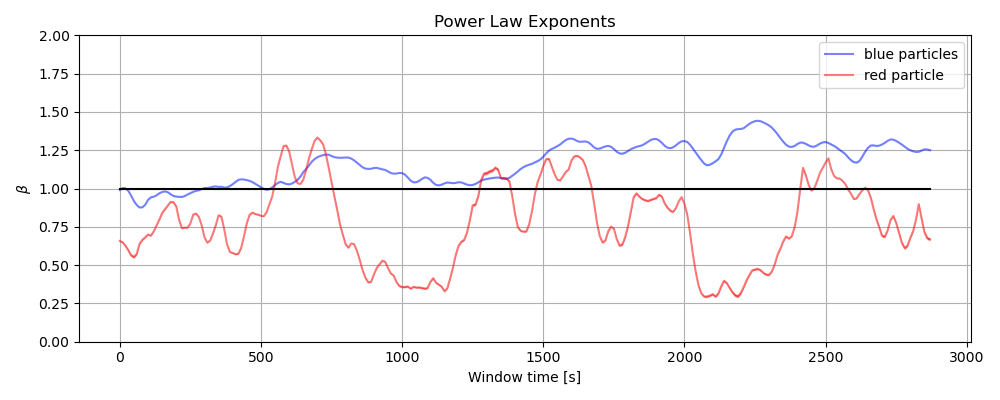

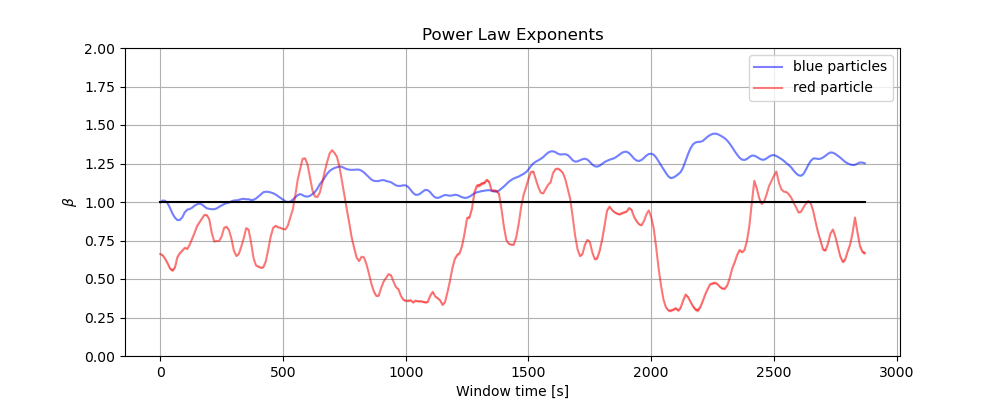

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title(f"Power Law Exponents")
ax.plot(startFrames/10, fit_dict["pw_exp_wind_b"][:, 0, 1], 'b-', alpha = 0.5, label = 'blue particles')
ax.fill_between(startFrames/10, fit_dict["pw_exp_wind_b"][:, 0, 1] - fit_dict["pw_exp_wind_b"][:, 1, 1],     
                    fit_dict["pw_exp_wind_b"][:, 0, 1] + fit_dict["pw_exp_wind_b"][:, 1, 1],
                    alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.plot(startFrames/10, fit_dict["pw_exp_wind_r"][:, 0, 1], 'r-', alpha = 0.5, label = 'red particle ')
ax.fill_between(startFrames/10, fit_dict["pw_exp_wind_r"][:, 0, 1] - fit_dict["pw_exp_wind_r"][:, 1, 1],
                    fit_dict["pw_exp_wind_r"][:, 0, 1] + fit_dict["pw_exp_wind_r"][:, 1, 1],
                    alpha=0.5, edgecolor='#F0FFFF', facecolor='#FF0000')
ax.plot(startFrames/10, np.ones(nSteps), 'k-')
ax.legend()
ax.grid()
ax.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
plt.tight_layout()
if save_verb: plt.savefig('../results/mean_squared_displacement/EMSD_beta_raw.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title(f"Power Law Exponents")
ax.plot(startFrames/10, fit_dict_smooth["pw_exp_wind_b"][:, 0, 1], 'b-', alpha = 0.5, label = 'blue particles')
ax.fill_between(startFrames/10,  fit_dict_smooth["pw_exp_wind_b"][:, 0, 1] -  fit_dict_smooth["pw_exp_wind_b"][:, 1, 1],     
                     fit_dict_smooth["pw_exp_wind_b"][:, 0, 1] +  fit_dict_smooth["pw_exp_wind_b"][:, 1, 1],
                    alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.plot(startFrames/10, fit_dict_smooth["pw_exp_wind_r"][:, 0, 1], 'r-', alpha = 0.5, label = 'red particle ')
ax.fill_between(startFrames/10,  fit_dict_smooth["pw_exp_wind_r"][:, 0, 1] -  fit_dict_smooth["pw_exp_wind_r"][:, 1, 1],
                        fit_dict_smooth["pw_exp_wind_r"][:, 0, 1] +  fit_dict_smooth["pw_exp_wind_r"][:, 1, 1],
                        alpha=0.5, edgecolor='#F0FFFF', facecolor='#FF0000')
ax.plot(startFrames/10, np.ones(nSteps), 'k-')
ax.legend()
ax.grid()
ax.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
if save_verb: plt.savefig('../results/mean_squared_displacement/EMSD_beta_smooth.png', dpi = 500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# Speed Distribution

$$ \huge p(v) = \frac{v}{\sigma^2} e^{-\frac{v^2}{2\sigma^2}} $$

In [ ]:
blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs) 

bin_borders = np.arange(0, 100, .2)
bin_centers = np.arange(0, 100, .2)[:-1] + .2 / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

v_blue = ys.speed_ensemble(blueTrajs, step = 10)
v_red = ys.speed_ensemble(redTraj, step = 10)
T_blue, T_blue_std = fit_hist(v_blue, bin_borders, MB_2D, [1.])
T_red, T_red_std = fit_hist(v_red, bin_borders, MB_2D, [1.])
print(f"Blue fit sigma: {T_blue[0]}", f"{T_blue_std[0]}")
print(f"Red fit sigma: {T_red[0]}", f"{T_red_std[0]}")


v_blue_smooth = ys.speed_ensemble(blueTrajs_smooth, step = 10)
v_red_smooth = ys.speed_ensemble(redTraj_smooth, step = 10)
T_blue_smooth, T_blue_smooth_std = fit_hist(v_blue_smooth, bin_borders, MB_2D, [1.])
T_red_smooth, T_red_smooth_std = fit_hist(v_red_smooth, bin_borders, MB_2D, [1.])
print(f"Blue fit sigma: {T_blue_smooth[0]}", f"{T_blue_smooth_std[0]}")
print(f"Red fit sigma: {T_red_smooth[0]}", f"{T_red_smooth_std[0]}")

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 5))
ax.hist(v_blue, bins = bin_borders, **default_kwargs_blue)
ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_blue), 'k-', label = f"$T = {T_blue[0]:.2f} \pm {T_blue_std[0]:.2f}$")
ax.set(title = "Blue particles velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()

ax1.hist(v_red, bins = bin_borders, **default_kwargs_red)
ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_red), 'k-', label = f"$T = {T_red[0]:.2f} \pm {T_red_std[0]:.2f}$")
ax1.set(title = "Red particle velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()

plt.suptitle("Raw trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/speed_distribution/speed_raw.png", bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 5))
ax.hist(v_blue_smooth, bins = bin_borders, **default_kwargs_blue)
ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_blue_smooth), 'k-', 
            label = f"$T = {T_blue_smooth[0]:.2f} \pm {T_blue_smooth_std[0]:.2f}$")
ax.set(title = "Blue particles velocity distribution", xlabel = f"speed [{units}]", 
            ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()

ax1.hist(v_red_smooth, bins = bin_borders, **default_kwargs_red)
ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_red_smooth), 'k-', 
            label = f"$T = {T_red_smooth[0]:.2f} \pm {T_red_smooth_std[0]:.2f}$")
ax1.set(title = "Red particle velocity distribution", xlabel = f"speed [{units}]",
            ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()
plt.suptitle("Smooth trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/speed_distribution/speed_smooth.png", bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

## Windowed Analysis

In [ ]:
v_blue_wind, v_red_wind = speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, rawTrajs)
blue_fit_wind = np.ones((nSteps, 2))
red_fit_wind = np.ones((nSteps, 2))

for k in range(nSteps):
    blue_fit_wind[k, 0], blue_fit_wind[k, 1] = fit_hist(v_blue_wind[k], bin_borders, MB_2D, [1.])
    red_fit_wind[k, 0], red_fit_wind[k, 1] = fit_hist(v_red_wind[k], bin_borders, MB_2D, [1.])


v_blue_wind_smooth, v_red_wind_smooth = speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, smoothTrajs)
blue_fit_wind_smooth = np.ones((nSteps, 2))
red_fit_wind_smooth = np.ones((nSteps, 2))

for k in range(nSteps):
    blue_fit_wind_smooth[k, 0], blue_fit_wind_smooth[k, 1] = fit_hist(v_blue_wind_smooth[k], bin_borders, MB_2D, [1.])
    red_fit_wind_smooth[k, 0], red_fit_wind_smooth[k, 1] = fit_hist(v_red_wind_smooth[k], bin_borders, MB_2D, [1.])

### PLOT

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        # update titles
        title.set_text(f"Raw Trajectories - window {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        #title2.set_text(f"Red particle velocity pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")

        # update histogram 1
        n, _ = np.histogram(v_blue_wind[frame], bin_borders, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        
        line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_wind[frame, 0]))

        # update histogram 2
        n2, _ = np.histogram(v_red_wind[frame], bin_borders, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
            
        line1.set_ydata(MB_2D(x_interval_for_fit, red_fit_wind[frame, 0]))

        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(v_blue_wind[0], bin_borders, **default_kwargs_blue, label="blue particles")
title = ax.set_title(f"Raw Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind[0, 0]), label='fit')
ax.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()

_, _, bar_container2 = ax1.hist(v_red_wind[0], bin_borders,  **default_kwargs_red, label="red particle")
#title2 = ax1.set_title(f"Red particle velocity pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
line1, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_wind[0, 0]), label='fit')
ax1.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
if save_verb: ani.save('../results/speed_distribution/speed_raw_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        # update titles
        title.set_text(f"Smooth Trajectories - window {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        #title2.set_text(f"Red particle velocity pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")

        # update histogram 1
        n, _ = np.histogram(v_blue_wind_smooth[frame], bin_borders, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        
        line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_wind_smooth[frame, 0]))

        # update histogram 2
        n2, _ = np.histogram(v_red_wind_smooth[frame], bin_borders, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
            
        line1.set_ydata(MB_2D(x_interval_for_fit, red_fit_wind_smooth[frame, 0]))

        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(v_blue_wind_smooth[0], bin_borders, **default_kwargs_blue, label="blue particles")
title = ax.set_title(f"Raw Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind_smooth[0, 0]), label='fit')
ax.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()

_, _, bar_container2 = ax1.hist(v_red_wind_smooth[0], bin_borders,  **default_kwargs_red, label="red particle")
#title2 = ax1.set_title(f"Red particle velocity pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
line1, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_wind_smooth[0, 0]), label='fit')
ax1.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
if save_verb: ani.save('../results/speed_distribution/speed_smooth_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 4), sharex=True)
ax.errorbar(startFrames/10, blue_fit_wind[:, 0], yerr = blue_fit_wind[:, 1], fmt = 'b', label="blue particles")
ax.set(ylabel = "T [??]", ylim = (1, 5), title = "Effective Temperature - Raw Trajectories")
ax.legend()
ax.grid()

ax1.errorbar(startFrames/10, red_fit_wind[:, 0], yerr = red_fit_wind[:, 1], fmt = 'r', label="red particles")
ax1.set(xlabel ="time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/speed_distribution/T_eff_raw.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

    
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 4), sharex=True)
ax.errorbar(startFrames/10, blue_fit_wind_smooth[:, 0], yerr = blue_fit_wind_smooth[:, 1], fmt = 'b', label="blue particles")
ax.set(ylabel = "T [??]", ylim = (1, 5), title = "Effective Temperature - Smooth Trajectories")
ax.legend()
ax.grid()

ax1.errorbar(startFrames/10, red_fit_wind_smooth[:, 0], yerr = red_fit_wind_smooth[:, 1], fmt = 'r', label="red particles")
ax1.set(xlabel = "time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/speed_distribution/T_eff_smooth.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# Turning Angles Distribution

$$ \huge f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

In [ ]:
blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)

bin_borders_turn = np.arange(-np.pi, np.pi + 0.0001, np.pi/50)
bin_centers_turn = bin_borders_turn[:-1] + np.diff(bin_borders_turn) / 2
x_interval_for_fit_turn = np.linspace(bin_borders_turn[0], bin_borders_turn[-1], 10000)

theta_blue = ys.turning_angles_ensemble(blueTrajs, centered = True)
theta_red = ys.turning_angles_ensemble(redTraj, centered = True)
# normal distribution fit
T_blue_rot, T_blue_rot_std = fit_hist(theta_blue, bin_borders_turn, normal_distr, [1., 0.])
T_red_rot, T_red_rot_std = fit_hist(theta_red, bin_borders_turn, normal_distr, [1., 0.])
print(f"Blue fit sigma: {T_blue_rot[0]}", f"{T_blue_rot_std[0]}")
print(f"Blue fit mu: {T_blue_rot[1]}", f"{T_blue_rot_std[1]}")
print(f"Red fit sigma: {T_red_rot[0]}", f"{T_red_rot_std[0]}")
print(f"Red fit mu: {T_red_rot[1]}", f"{T_red_rot_std[1]}")


theta_blue_smooth = ys.turning_angles_ensemble(blueTrajs_smooth, centered = True)
theta_red_smooth = ys.turning_angles_ensemble(redTraj_smooth, centered = True)
# normal distribution fit
T_blue_rot_smooth, T_blue_rot_smooth_std = fit_hist(theta_blue_smooth, bin_borders_turn, normal_distr, [1., 0.])
T_red_rot_smooth, T_red_rot_smooth_std = fit_hist(theta_red_smooth, bin_borders_turn, normal_distr, [1., 0.])
print(f"Blue fit sigma: {T_blue_rot_smooth[0]}", f"{T_blue_rot_smooth_std[0]}")
print(f"Blue fit mean: {T_blue_rot_smooth[1]}", f"{T_blue_rot_smooth_std[1]}")
print(f"Red fit sigma: {T_red_rot_smooth[0]}", f"{T_red_rot_smooth_std[0]}")
print(f"Red fit mean: {T_red_rot_smooth[1]}", f"{T_red_rot_smooth_std[1]}")

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.hist(theta_blue, bin_borders_turn, **default_kwargs_blue, label="blue particles")
ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *T_blue_rot), 'k-',
                label = f"$T = {T_blue_rot[0]:.2f} \pm {T_blue_rot_std[0]:.2f}$")
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.legend()
ax.set_ylim(0,0.5)

ax1.hist(theta_red, bin_borders_turn, **default_kwargs_red, label="red particle")
ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *T_red_rot), 'k-',
                label = f"$T = {T_red_rot[0]:.2f} \pm {T_red_rot_std[0]:.2f}$")
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax1.legend()
ax1.set_ylim(0,0.5)
plt.suptitle("Turning angles pdf - Raw trajectories")
if save_verb: plt.savefig(f"../results/turning_angles/turn_ang_raw.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.hist(theta_blue_smooth, bin_borders_turn, **default_kwargs_blue, label="blue particles")
ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn,* T_blue_rot_smooth), 'k-',
                label = f"$T = {T_blue_rot_smooth[0]:.2f} \pm {T_blue_rot_smooth_std[0]:.2f}$")
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.legend(prop={'size': 8})

ax1.hist(theta_red_smooth, bin_borders_turn, **default_kwargs_red, label="red particle")
ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *T_red_rot_smooth), 'k-',
                label = f"$T = {T_red_rot_smooth[0]:.2f} \pm {T_red_rot_smooth_std[0]:.2f}$")
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax1.legend(prop={'size': 8})

plt.suptitle("Turning angles pdf - Smooth trajectories")
if save_verb: plt.savefig(f"../results/turning_angles/turn_ang_smooth.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()

## Windowed Analysis

In [ ]:
theta_blue_wind, theta_red_wind = theta_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, rawTrajs)
theta_blue_wind_smooth, theta_red_wind_smooth = theta_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, smoothTrajs)

blue_fit_wind_turn = np.ones((nSteps, 2, 2))
red_fit_wind_turn = np.ones((nSteps, 2, 2))

for k in range(nSteps):
    blue_fit_wind_turn[k, 0], blue_fit_wind_turn[k, 1] = fit_hist(theta_blue_wind[k], bin_borders_turn, normal_distr, [1., 0.])
    red_fit_wind_turn[k, 0], red_fit_wind_turn[k, 1] = fit_hist(theta_red_wind[k], bin_borders_turn, normal_distr, [1., 0.])

blue_fit_wind_turn_smooth = np.ones((nSteps, 2, 2))
red_fit_wind_turn_smooth = np.ones((nSteps, 2, 2))

for k in range(nSteps):
    blue_fit_wind_turn_smooth[k, 0], blue_fit_wind_turn_smooth[k, 1] = fit_hist(theta_blue_wind_smooth[k], bin_borders_turn, normal_distr, [1., 0.])
    red_fit_wind_turn_smooth[k, 0], red_fit_wind_turn_smooth[k, 1] = fit_hist(theta_red_wind_smooth[k], bin_borders_turn, normal_distr, [1., 0.])

### PLOT

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        title.set_text(f"Turning angles pdf - Raw Trajectories - window {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        
        n, _ = np.histogram(theta_blue_wind[frame], bin_borders_turn, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        line.set_ydata(normal_distr(x_interval_for_fit_turn, *blue_fit_wind_turn[frame, 0]))
            
        #title2.set_text(f"Red particle turning angles pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        n2, _ = np.histogram(theta_red_wind[frame], bin_borders_turn, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
        line1.set_ydata(normal_distr(x_interval_for_fit_turn, *red_fit_wind_turn[frame, 0]))
            
        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(theta_red_wind[0], bin_borders_turn, **default_kwargs_blue, label="blue particles")
line, = ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *blue_fit_wind_turn[0, 0]), label='fit')
title = ax.set_title(f"Turning angles pdf - Raw Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
ax.set(ylabel = "pdf", ylim = (0, 1))
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

_, _, bar_container2 = ax1.hist(theta_red_wind[0], bin_borders_turn,  **default_kwargs_red, label="red particle")
line1, = ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *red_fit_wind_turn[0, 0]), label='fit')
#title2 = ax1.set_title(f"Red particle turning angles pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
ax1.set(ylabel = "pdf", ylim = (0, 1))
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])


plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
if save_verb: ani.save('../results/turning_angles/turn_ang_wind_raw.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

if anim_show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        title.set_text(f"Turning angles pdf - Smooth Trajectories - window {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        n, _ = np.histogram(theta_blue_wind_smooth[frame], bin_borders_turn, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        line.set_ydata(normal_distr(x_interval_for_fit_turn, *blue_fit_wind_turn_smooth[frame, 0]))
            
        n2, _ = np.histogram(theta_red_wind_smooth[frame], bin_borders_turn, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
        
        line1.set_ydata(normal_distr(x_interval_for_fit_turn, *red_fit_wind_turn_smooth[frame, 0]))
            
        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(theta_red_wind_smooth[0], bin_borders_turn, **default_kwargs_blue, label="blue particles")
line, = ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *blue_fit_wind_turn_smooth[0, 0]), label='fit')
title = ax.set_title(f"Turning angles pdf - Smooth Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")

ax.set(ylabel = "pdf", ylim = (0, 3))
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

_, _, bar_container2 = ax1.hist(theta_red_wind_smooth[0], bin_borders_turn,  **default_kwargs_red, label="red particle")
line1, = ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *red_fit_wind_turn_smooth[0, 0]), label='fit')
ax1.set(ylabel = "pdf", ylim = (0, 3))
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
ani.save('../results/turning_angles/turn_ang_wind_smooth.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax.plot(startFrames/10, blue_fit_wind_turn[:, 0, 0], 'b', label="blue particles")
ax.fill_between(startFrames/10, blue_fit_wind_turn[:, 0, 0] - blue_fit_wind_turn[:, 1, 0],
                 blue_fit_wind_turn[:, 0, 0] + blue_fit_wind_turn[:, 1, 0], color='b', alpha=0.2)
ax.set(ylabel = "T [??]", title = "Effective Temperature - Raw Trajectories")
ax.legend()
ax.grid()

ax1.plot(startFrames/10, red_fit_wind_turn[:, 0, 0], 'r', label="red particles")
ax1.fill_between(startFrames/10, red_fit_wind_turn[:, 0, 0] - red_fit_wind_turn[:, 1, 0],
                    red_fit_wind_turn[:, 0, 0] + red_fit_wind_turn[:, 1, 0], color='r', alpha=0.2)
ax1.set(xlabel ="time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/turning_angles/effective_T_raw.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax.plot(startFrames/10, blue_fit_wind_turn_smooth[:, 0, 0], 'b', label="blue particles")
ax.fill_between(startFrames/10, blue_fit_wind_turn_smooth[:, 0, 0] - blue_fit_wind_turn_smooth[:, 1, 0],
                    blue_fit_wind_turn_smooth[:, 0, 0] + blue_fit_wind_turn_smooth[:, 1, 0], color='b', alpha=0.2)
ax.set(ylabel = "T [??]", title = "Rotational effective temperature - Smooth Trajectories")
ax.legend()
ax.grid()

ax1.plot(startFrames/10, red_fit_wind_turn_smooth[:, 0, 0], 'r', label="red particles")
ax1.fill_between(startFrames/10, red_fit_wind_turn_smooth[:, 0, 0] - red_fit_wind_turn_smooth[:, 1, 0],
                        red_fit_wind_turn_smooth[:, 0, 0] + red_fit_wind_turn_smooth[:, 1, 0], color='r', alpha=0.2)
ax1.set(xlabel = "time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/turning_angles/T_eff_smooth.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# Velocity autocorrelation
[ref](https://en.wikipedia.org/wiki/Autocovariance)

note: yupi vacf in time_avg mode performs autocovariance actually, not the autocorrelation

$$ K_{XX}(t_1, t_2) = cov \big[X_{t_1} , X_{t_2} \big] = E \big[ (X_{t_1} - \mu_{t_1}) (X_{t_2} - \mu_{t_2}) \big] = E \big[ X_{t_1}, X_{t_2} \big] - \mu_{t_1} \mu_{t_2} $$


$$ K_{XX}(\tau) = E \big[ (X_t - \mu_t) (X_{t-\tau} - \mu_t) \big] $$

todo: modify code of yupy to get autocovariance at lag time 0 obtaining $\sigma^2$, which can be used to normalize the autocovariance

done: modified yupi source code at ../pyenv/lib/python3.10/site-packages/yupi/stats/_stats.py, 

original :

    for lag_ in range(1, lag + 1):
        # Multiply components given lag
        v1, v2 = v[:-lag_], v[lag_:]
        v1v2 = (v1 - v1.mean(axis=0)) * (v2 - v2.mean(axis=0))

        # Dot product for a given lag time
        v1_dot_v2 = np.sum(v1v2, axis=1)

        # Averaging over a single realization
        current_vacf[lag_ - 1] = np.mean(v1_dot_v2)


    vacf_mean = np.mean(_vacf, axis=1)  # Mean    
    vacf_std = np.std(_vacf, axis=1)  # Standard deviation

modified:

    for lag_ in range(lag):
        if lag_ == 0: v1, v2 = v[:], v[:]
        else: v1, v2 = v[:-lag_], v[lag_:]
        # Multiply components given lag
        v1v2 = (v1 - v1.mean(axis=0)) * (v2 - v2.mean(axis=0))

        # Dot product for a given lag time
        v1_dot_v2 = np.sum(v1v2, axis=1)

        # Averaging over a single realization
        current_vacf[lag_] = np.mean(v1_dot_v2)
                    

    vacf_mean = np.mean(_vacf/_vacf[0], axis=1)  # Mean
    vacf_std = np.std(_vacf/_vacf[0], axis=1)  # Standard deviation

In [ ]:
maxLagtime = 1000
#x = np.arange(0.1, 100.1, 0.1) # without initial point
x = np.arange(0, 100, 0.1) # with initial point

In [ ]:
blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)

maxLagtime = 1000
#x = np.arange(0.1, 100.1, 0.1) # without initial point
x = np.arange(0, 100, 0.1) # with initial point

vacf_mean_blue, vacf_std_blue = ys.vacf(blueTrajs, time_avg=True, lag = maxLagtime)
vacf_mean_red, vacf_std_red = ys.vacf(redTraj, time_avg=True, lag = maxLagtime)
vacf_mean_blue_smooth, vacf_std_blue_smooth = ys.vacf(blueTrajs_smooth, time_avg=True, lag=maxLagtime)
vacf_mean_red_smooth, vacf_std_red_smooth = ys.vacf(redTraj_smooth, time_avg=True, lag=maxLagtime)

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 5))
ax.errorbar(x, vacf_mean_blue/vacf_mean_blue[0], fmt='o', markersize=1, color = "blue", label = 'blue particles')
# ax.fill_between(x, vacf_mean_blue + vacf_std_blue, vacf_mean_blue - vacf_std_blue,
#                     alpha=1, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.grid()
ax.legend()
ax.set(xlim=(-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax1.errorbar(x, vacf_mean_red, yerr=vacf_std_red, fmt='o',
                 markersize=1, color = "red", label = 'red particle')
ax1.set(xlim=(-1, 40), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax1.grid()
ax1.legend()
plt.suptitle("Velocity autocorrelation function- Raw trajectories")
plt.tight_layout()
if 0: plt.savefig("../results/velocity_autocovariance/vacf_raw.png", dpi = 500, bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 5))
ax.errorbar(x, vacf_mean_blue_smooth/vacf_mean_blue_smooth[0], fmt='o', markersize=1, color = "blue", label = 'blue particles')
#ax.fill_between(x, vacf_mean_blue_smooth + vacf_std_blue_smooth, vacf_mean_blue_smooth - vacf_std_blue_smooth,
#                     alpha=1, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.set(xlim=(-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax.grid()
ax.legend()
ax1.errorbar(x, vacf_mean_red_smooth, yerr=vacf_std_red_smooth, fmt='o',
                 markersize=1, color = "red", label = 'red particle')
ax1.set(xlim=(-1, 40), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax1.grid()  
ax1.legend()
plt.suptitle("Velocity autocorrelation function - Smooth trajectories")
plt.tight_layout()
if 0: plt.savefig("../results/velocity_autocovariance/vacf_smooth.png", dpi = 500, bbox_inches='tight')
plt.show()
if show_verb: 
    plt.show()
else:
    plt.close()

## Windowed Analysis 

In [ ]:
if 1: 
    vacf_blue_windowed = []
    vacf_red_windowed = []

    for k in tqdm(range(nSteps)):
        trajs = rawTrajs.loc[rawTrajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs = []
        redTraj = []

        for i in range(0, nDrops):
            if i == red_particle_idx:
                p = trajs.loc[trajs.particle==i, ["x","y"]]
                redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
            else:
                p = trajs.loc[trajs.particle==i, ["x","y"]]
                blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

        vacf_blue_windowed.append(ys.vacf(blueTrajs, time_avg=True, lag=maxLagtime)[0])
        vacf_red_windowed.append(ys.vacf(redTraj, time_avg=True, lag=maxLagtime)[0])
        
    vacf_blue_windowed = pd.DataFrame(vacf_blue_windowed)
    vacf_red_windowed = pd.DataFrame(vacf_red_windowed)
    vacf_blue_windowed.to_csv("../data/analysis/vacf/vacf_blue_wind_raw.csv")
    vacf_red_windowed.to_csv("../data/analysis/vacf/vacf_red_wind_raw.csv")
else:
    vacf_blue_windowed = pd.read_csv("../data/analysis/vacf/vacf_blue_wind_raw.csv", index_col=0)
    vacf_red_windowed = pd.read_csv("../data/analysis/vacf/vacf_red_wind_raw.csv", index_col=0)

In [ ]:
fig = plt.figure(figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    line.set_ydata(vacf_blue_windowed.iloc[step])
    #ax.set_ylim(1.2*min(vacf_blue_windowed.iloc[step]), 1.2*max(vacf_blue_windowed.iloc[step]))
    title.set_text(f"Velocity autocorrelation - Raw Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    #ax1.set_ylim(1.2*min(vacf_red_windowed.iloc[step])-10, 1.2*max(vacf_red_windowed.iloc[step]))
    line1.set_ydata(vacf_red_windowed.iloc[step])
    return line, line1,

ax = fig.add_subplot(211)
title = ax.set_title(f"Velocity autocorrelation - Raw Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
line, = ax.plot(np.arange(0.1, 100.1, 0.1), vacf_blue_windowed.iloc[0], 'b-', label = 'Blue particles')
ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.2))
ax.grid()
ax.legend()

ax1 = fig.add_subplot(212)

line1, = ax1.plot(np.arange(0.1, 100.1, 0.1), vacf_red_windowed.iloc[0], 'r-', label = 'Red particle')
ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.2))
ax1.grid()
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/velocity_autocovariance/vacf_windowed_raw_with_initial_point.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

## Windowed Analysis - Smooth Trajectory

In [ ]:
if 1:
    vacf_blue_windowed_smooth = []
    vacf_red_windowed_smooth = []

    for k in tqdm(range(nSteps)):
        trajs = smoothTrajs.loc[smoothTrajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs = []
        redTraj = []

        for i in range(0, nDrops):
            if i == red_particle_idx:
                p = trajs.loc[trajs.particle==i, ["x","y"]]
                redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
            else:
                p = trajs.loc[trajs.particle==i, ["x","y"]]
                blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
            
        vacf_blue_windowed_smooth.append(ys.vacf(blueTrajs, time_avg=True, lag=maxLagtime)[0])
        vacf_red_windowed_smooth.append(ys.vacf(redTraj, time_avg=True, lag=maxLagtime)[0])
    
    vacf_blue_windowed_smooth = pd.DataFrame(vacf_blue_windowed_smooth)
    vacf_red_windowed_smooth = pd.DataFrame(vacf_red_windowed_smooth)
    vacf_blue_windowed_smooth.to_csv("../data/analysis/vacf/vacf_blue_wind_smooth.csv")
    vacf_red_windowed_smooth.to_csv("../data/analysis/vacf/vacf_red_wind_smooth.csv")
else:
    vacf_blue_windowed_smooth = pd.read_csv("../data/analysis/vacf/vacf_blue_wind_smooth.csv", index_col=0)
    vacf_red_windowed_smooth = pd.read_csv("../data/analysis/vacf/vacf_red_wind_smooth.csv", index_col=0)

In [ ]:
fig = plt.figure(figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    line.set_ydata(vacf_blue_windowed_smooth.iloc[step])
    ax.set_ylim(1.5*min(vacf_blue_windowed_smooth.iloc[step])-10, 1.5*max(vacf_blue_windowed_smooth.iloc[step])-10)
    title.set_text(f"Velocity autocorrelation - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    ax1.set_ylim(1.5*min(vacf_red_windowed_smooth.iloc[step])-10, 1.5*max(vacf_red_windowed_smooth.iloc[step])-10)
    line1.set_ydata(vacf_red_windowed_smooth.iloc[step])
    return line, line1,

ax = fig.add_subplot(211)
title = ax.set_title(f"Velocity autocorrelation - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
line, = ax.plot(np.arange(0.1, 100.1, 0.1), vacf_blue_windowed_smooth.iloc[0], 'b-', label = 'Blue particles')
ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20))
ax.grid()
ax.legend()

ax1 = fig.add_subplot(212)
line1, = ax1.plot(np.arange(0.1, 100.1, 0.1), vacf_red_windowed_smooth.iloc[0], 'r-', label = 'Red particle')
ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20))
ax1.grid()
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/velocity_autocovariance/vacf_windowed_smooth_with_initial_point.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()